## Objective:
The objective of this app is to predict the approved loan amount for applicants based on their profile information.

## Problem Statement:
The challenge is to develop a prediction model that can accurately determine the loan amount that will be granted to an applicant, considering factors like credit score, co-applicant status, and requested loan amount.

## Executive Summary 🏦💲📈:

- Our loan prediction app utilizes applicant profile details to estimate loan amounts, with credit scores and co-applicants significantly influencing larger approvals. During target variable inspection, many instances had zero loan sanction, and the distribution exhibited skewness. Scaling data for "Loan Amount Request (USD)," "Current Loan Expenses (USD)," and "Property Price" addresses this.

- Income (USD) distribution reveals varying proportions across income categories. Relationship analysis indicates balanced correlations between gender, income stability, no defaults, and loan sanction amounts. Urban locations have slightly higher sanctions, while "Working" and "Commercial associate" professions show higher loan approvals.

- Numeric variables show a positive correlation with loan sanction, with more credits and co-applicants increasing approval chances. Certain thresholds impact the target value for Loan Amount Requested, Current Loan Expenses, Property Price, and Age.

- Correlation analysis shows little multicollinearity concern, except for "Loan Amount Request" and "Property Price," which are reasonably correlated due to property price influence.

- The most predictive features for loan sanction are Loan Amount Requested, Credit Score, Co-Applicant, Income, and Property Price, while expense types and gender have less impact. Recommendations include focusing on highly predictive features during applicant profiling and giving less weight to less predictive features.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import chi2, mutual_info_regression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore');

C:\Users\Biniam\AppData\Local\Temp\ipykernel_9228\1277111957.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


### Data Validation Summary:🔍🔒

1. Lack of metadata for certain features, such as expenses types and property types, requiring clarification.

2. Target feature "Loan Sanction Amount (USD)" exhibits zero-inflation.
3. Dataset needs cleaning due to uncleaned entries and several null values.
4. Data types in the test set ("Co-Applicant" and "Property Price") do not match the training dataset.
5. "Income (USD)" and "Property Age" show identical values, suggesting potential redundancy.
6. Null values found in the target feature "Loan Sanction Amount (USD)."
7. Most columns have no missing values, and overall percentage of missing values is low.
8. Sufficient data with 30,000 observations is available for training.
9. "Co-Applicant," "Property Price," and "Property Type" data types in test data do not match actual value types.
10. No duplicate rows exist in the training dataset.
"Customer Id" and "Name" cannot provide insights into the target value, unlike the pre-existing "Gender" feature.
After data validation, the dataset contains 30,000 rows and 24 columns.

#### Loading the dataset
- Data Overview
    - View the first and last 5 rows of Original Dataset

In [2]:
train_df = pd.read_csv('../datasets/train.csv')
test_df = pd.read_csv('../datasets/test.csv')

# cheking the datasets shape
train_rows, train_cols = train_df.shape[0], train_df.shape[1]
test_rows, test_cols = test_df.shape[0], test_df.shape[1]


print(f"The training dataframe has {train_rows} rows and {train_cols} cols")
print(f"The training dataframe has {test_rows} rows and {test_cols} cols")

The training dataframe has 30000 rows and 24 cols
The training dataframe has 20000 rows and 23 cols


In [3]:
pd.set_option('display.max_columns', None)
train_df.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [4]:
#Check the data types of the columns for the datasets
print("TRAINING SET:\n")
train_df.info()

TRAINING SET:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  30000 non-null  object 
 1   Name                         30000 non-null  object 
 2   Gender                       29947 non-null  object 
 3   Age                          30000 non-null  int64  
 4   Income (USD)                 25424 non-null  float64
 5   Income Stability             28317 non-null  object 
 6   Profession                   30000 non-null  object 
 7   Type of Employment           22730 non-null  object 
 8   Location                     30000 non-null  object 
 9   Loan Amount Request (USD)    30000 non-null  float64
 10  Current Loan Expenses (USD)  29828 non-null  float64
 11  Expense Type 1               30000 non-null  object 
 12  Expense Type 2               30000 non-null  object 
 13  D

#### Validating each categorical variable

checking cardiniality

In [5]:
#Making a list of all catrgorical variables 
cat_col=['Gender', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 
         'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location']

#Printing number of count of each unique value in each column
for column in cat_col:
 print(train_df[column].value_counts(dropna=False))
 print('-'*50)

M      15053
F      14894
NaN       53
Name: Gender, dtype: int64
--------------------------------------------------
Low     25751
High     2566
NaN      1683
Name: Income Stability, dtype: int64
--------------------------------------------------
Working                 16926
Commercial associate     7962
Pensioner                2740
State servant            2366
Unemployed                  2
Businessman                 2
Student                     1
Maternity leave             1
Name: Profession, dtype: int64
--------------------------------------------------
NaN                      7270
Laborers                 5578
Sales staff              3736
Core staff               3230
Managers                 2495
Drivers                  1606
Accountants              1379
High skill tech staff    1307
Medicine staff            864
Security staff            579
Cooking staff             566
Private service staff     342
Cleaning staff            341
Low-skill Laborers        162
Secretaries

In [6]:
def uniqueness(df):
    """"Calculates the number of unique values, the actual unique values, and the variable type of each column in a given pandas DataFrame.
    """
    variables = pd.DataFrame(columns=['Variable','Number of unique values','Values', 'Variable types'])

    for i, var in enumerate(df.columns):
        variables.loc[i] = [var, df[var].nunique(),df[var].unique().tolist(), df[var].dtype]
    variables.set_index('Variable', inplace=True)    
    return variables.sort_values('Number of unique values', ascending=False)
uniqueness(train_df)

,Number of unique values,Values,Variable types
Variable,,,
Customer ID,30000,"[C-36995, C-33999, C-3770, C-26480, C-23459, C...",object
Name,30000,"[Frederica Shealy, America Calderone, Rosetta ...",object
Loan Amount Request (USD),29982,"[72809.58, 46837.47, 45593.04, 80057.92, 11385...",float64
Property Price,29632,"[119933.46, 54791.0, 72440.58, 121441.51, 2085...",float64
Income (USD),24429,"[1933.05, 4952.91, 988.19, nan, 2614.77, 1234....",float64
Property Age,24179,"[1933.05, 4952.91, 988.19, nan, 2614.77, 1234....",float64
Current Loan Expenses (USD),24041,"[241.08, 495.81, 171.95, 298.54, 491.41, 181.4...",float64
Loan Sanction Amount (USD),21450,"[54607.18, 37469.98, 36474.43, 56040.54, 74008...",float64
Credit Score,17586,"[809.44, 780.4, 833.15, 832.7, 745.55, 684.12,...",float64


#### Validating numerical values 

In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,30000.0,40.092300,16.045129,18.00,25.0000,40.000,55.0000,65.00
Income (USD),25424.0,2630.574417,11262.723830,377.70,1650.4575,2222.435,3090.5925,1777460.21
Loan Amount Request (USD),30000.0,88826.333855,59536.949605,6048.24,41177.7550,75128.075,119964.6050,621497.82
Current Loan Expenses (USD),29828.0,400.936876,242.545375,-999.00,247.6675,375.205,521.2925,3840.88
Dependents,27507.0,2.253027,0.951162,1.00,2.0000,2.000,3.0000,14.00
Credit Score,28297.0,739.885381,72.163846,580.00,681.8800,739.820,799.1200,896.26
No. of Defaults,30000.0,0.193933,0.395384,0.00,0.0000,0.000,0.0000,1.00
Property ID,30000.0,501.934700,288.158086,1.00,251.0000,504.000,751.0000,999.00
Property Age,25150.0,2631.119440,11322.677000,377.70,1650.4500,2223.250,3091.4075,1777460.21
Property Type,30000.0,2.460067,1.118562,1.00,1.0000,2.000,3.0000,4.00


#### Checking for Missing Values

In [14]:
# total number of cells
train_cells, test_cells = (train_rows * train_cols), (test_rows * test_cols)
train_missing = train_df.isnull().sum().sum()
print(f"Missing number values in train set {round((train_missing / train_cells) * 100, 3)}%")

Missing number values in train set 3.481%


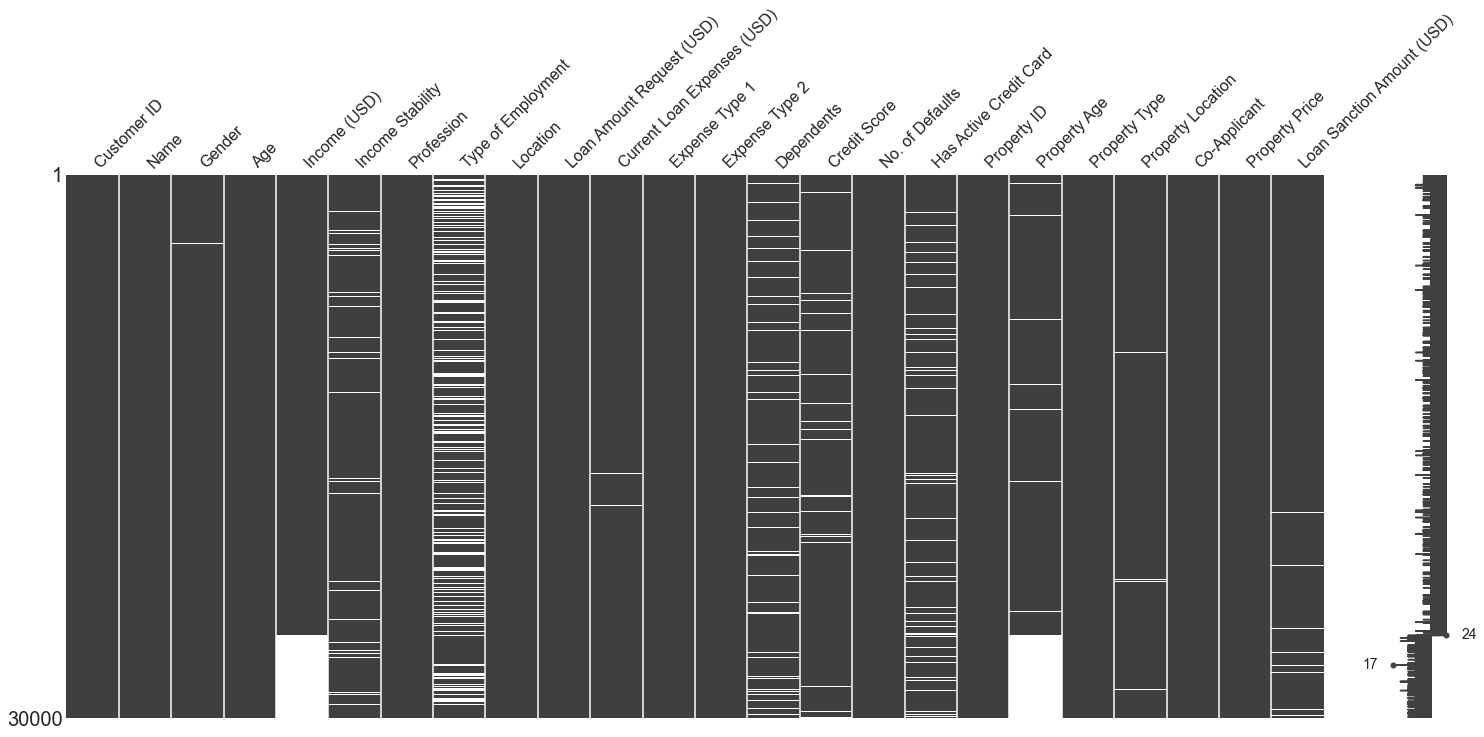

In [15]:
msn.matrix(train_df.sort_values('Income (USD)'))
plt.show()

In [3]:
def missing_data_percentage(df):
    """
    Calculates the percentage of missing values in each column of a given pandas DataFrame and displays the result.
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, round(percent,3)], axis=1, keys=['Total', 'Percent'])
    return display(missing_data)
missing_data_percentage(train_df)

,Total,Percent
Type of Employment,7270,0.242
Property Age,4850,0.162
Income (USD),4576,0.153
Dependents,2493,0.083
Credit Score,1703,0.057
Income Stability,1683,0.056
Has Active Credit Card,1566,0.052
Property Location,356,0.012
Loan Sanction Amount (USD),340,0.011
Current Loan Expenses (USD),172,0.006


#### Checking for explicit duplicates

In [4]:
duplicate_rows = train_df[train_df.duplicated()]
print("Number of duplicate rows Train: ", duplicate_rows.shape[0])

Number of duplicate rows Train:  0


### Data Cleaning:

1. Deleted NaN values in a column with less than or equal to 5% of missing data.

2. Created an additional binary feature indicating the presence of missing data in 'Type of Employment,' preserving it for valuable exploratory data analysis (EDA).
3. Dropped rows containing values of -999 in specific features for both training and test datasets, as they appeared unusual and suspicious. These features include 'Current Loan Expenses (USD),' 'Co-Applicant,' 'Property Price,' and 'Loan Sanction Amount (USD).' Moreover, 'Income (USD)' and 'Property Age' exhibited the same range in both datasets, raising doubts about potential duplicate columns, prompting their removal to avoid collinearity.
4. Filled in missing values in 'Type of Employment' and 'Has Active Credit Card' with "Unknown."
5. Cleaned 'Profession' data.
6. Dropped 'Property Age' from both training and test datasets due to potential redundancy.
7. Eliminated 'Customer ID,' 'Name,' and 'Property ID' as they were irrelevant to our prediction task.
8. Filled in missing values in the 'Credit Score' and 'Income (USD)' columns.

In [5]:
class DataProcessor:
    def __init__(self, df):
        self.df = df.copy()
        
        # Remove 5% range nan values
    def drop_rows_with_low_nan_percentage(self, threshold=5):
        nan_percentage = round((self.df.isnull().sum() / self.df.shape[0]) * 100, 3)
        columns_to_keep = nan_percentage[nan_percentage < threshold].index

        for col in columns_to_keep:
            if nan_percentage[col] <= threshold:
                self.df = self.df.dropna(subset=[col])
        return self.df
    
    def clean_train_data(self):
        int_to_object = {1: "property_type_1", 2: "property_type_2", 3: "property_type_3", 4: "Property_type_4"}
        self.df['Property Type'].replace(int_to_object, inplace=True)

        vars = ['Property Price', 'Co-Applicant', 'Current Loan Expenses (USD)', 'Loan Sanction Amount (USD)']
        (self.df[vars] == -999).sum()

        index_to_keep = (self.df[vars] != -999).all(axis=1)
        self.df = self.df.loc[index_to_keep]

        self.df['Type of Employment'] = self.df['Type of Employment'].fillna("Unknown")
        self.df['Has Active Credit Card'] = self.df['Has Active Credit Card'].fillna("Unknown")
        self.df['Dependents'] = self.df['Dependents'].fillna(0)
        self.df.loc[self.df['Income Stability'].isnull(), "Income Stability"] = "Low"

        self.df['Profession'] = self.df.groupby('Profession')['Profession'].transform(lambda x: x if x.count() > 5 else "Other")

        self.df['Loan Sanctioned'] = self.df['Loan Sanction Amount (USD)'] > 0
        return self.df

    def drop_features(self, feature_to_drop):
        if set(feature_to_drop).issubset(self.df.columns):
            self.df = self.df.drop(feature_to_drop, axis=1)
        else:
            print("One or more features are not in the dataframe")

    def fill_column(self, target, columns, grp_maps):
        target_series = self.df[target].copy()
        for grp in grp_maps:
            temp = self.df.copy()
            for index, col in enumerate(columns):
                temp = temp[temp[col] == grp[0][index]]
                index += 1
            temp_nulls = temp[temp[target].isnull()].index
            if len(temp_nulls) == 0:
                continue
            target_series.loc[temp_nulls] = grp[1]

        return target_series

    def fill_credit_score_and_income(self):
        PTE_gb = self.df.groupby(['Profession', 'Income Stability'])['Credit Score'].median()
        PTE_maps = list(zip(PTE_gb.index, PTE_gb.values))
        self.df['Credit Score'] = self.fill_column('Credit Score', ['Profession', 'Income Stability'], PTE_maps)

        PTEL_gb = self.df.groupby(['Profession', 'Type of Employment', 'Location'])['Income (USD)'].median()
        PTEL_maps = list(zip(PTEL_gb.index, PTEL_gb.values))
        self.df['Income (USD)'] = self.fill_column('Income (USD)', ['Profession', 'Type of Employment', 'Location'], PTEL_maps)
        self.df['Income (USD)'] = self.df['Income (USD)'].fillna(self.df['Income (USD)'].median())

        return self.df

In [6]:
class DataProcessorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df):
        return self

    def transform(self, df):
        data_processor = DataProcessor(df)
        data_processor.drop_rows_with_low_nan_percentage()
        data_processor.clean_train_data()
        feature_to_drop = ['Customer ID', 'Name', 'Property ID', 'Property Age']
        data_processor.drop_features(feature_to_drop)
        data_processed = data_processor.fill_credit_score_and_income()
        return data_processed


data_processor_transformer = DataProcessorTransformer()
pipeline = Pipeline([
    ('data_processor', data_processor_transformer)
])
cleaned_train = pipeline.fit_transform(train_df)

In [7]:
# For EDA purpose
def bin_column_into_categories(df, column_name, bin_edges, labels):
    
    df['{}_Category'.format(column_name)] = pd.cut(df[column_name], bins=bin_edges, labels=labels)
    
    return df

# Define the bin edges and labels for five categories
bin_edges = [0, 1000, 2000, 3000, 4000, float('inf')]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

cleaned_train = bin_column_into_categories(cleaned_train, 'Income (USD)', bin_edges, labels)

In [8]:
cleaned_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28143 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Gender                       28143 non-null  object  
 1   Age                          28143 non-null  int64   
 2   Income (USD)                 28143 non-null  float64 
 3   Income Stability             28143 non-null  object  
 4   Profession                   28143 non-null  object  
 5   Type of Employment           28143 non-null  object  
 6   Location                     28143 non-null  object  
 7   Loan Amount Request (USD)    28143 non-null  float64 
 8   Current Loan Expenses (USD)  28143 non-null  float64 
 9   Expense Type 1               28143 non-null  object  
 10  Expense Type 2               28143 non-null  object  
 11  Dependents                   28143 non-null  float64 
 12  Credit Score                 28143 non-null  float64 
 13  N

### Exploratory Data Analysis (EDA)📊
#### Inspecting the  Loan Sanction Amount (USD) our target variable
During the inspection of the target variable, it was observed that a significant number of values were zero, indicating instances where no loan sanction was given. The target variable exhibited skewness and peakedness, with two unusually high values, deviating from a normal distribution. To address the right-skewed pattern in the distribution, scaling the data is recommended, and this process will be applied to variables "Loan Amount Request (USD)," "Current Loan Expenses (USD)," and "Property Price" (Graphs 4-3 to 4-5) as they experience the same pattern.

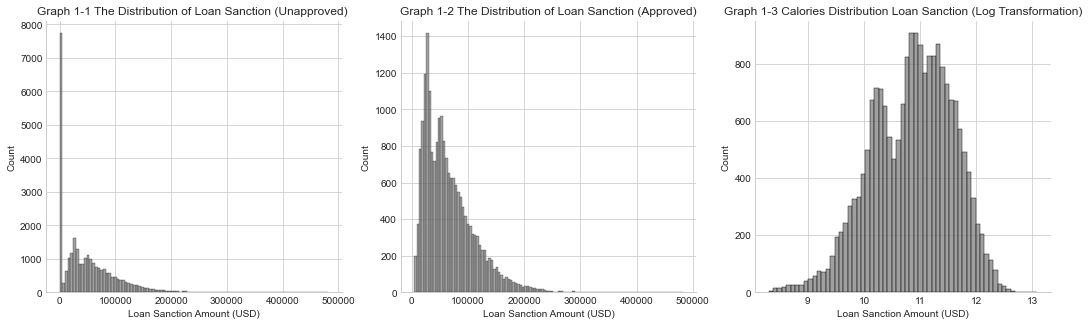

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 
cl = 'gray'
ax = sns.histplot(data=cleaned_train, x='Loan Sanction Amount (USD)', ax=axes[0], color=cl)
axes[0].set(title='Graph 1-1 The Distribution of Loan Sanction (Unapproved) ')

ax = sns.histplot(data=cleaned_train[cleaned_train['Loan Sanction Amount (USD)'] > 0], x='Loan Sanction Amount (USD)', ax=axes[1], color=cl)
axes[1].set(title='Graph 1-2 The Distribution of Loan Sanction (Approved)')

sns.histplot(data=cleaned_train, x=np.log(cleaned_train['Loan Sanction Amount (USD)']), ax=axes[2], color=cl)
axes[2].set_title('Graph 1-3 Calories Distribution Loan Sanction (Log Transformation)')
sns.despine(right=True)
plt.show()

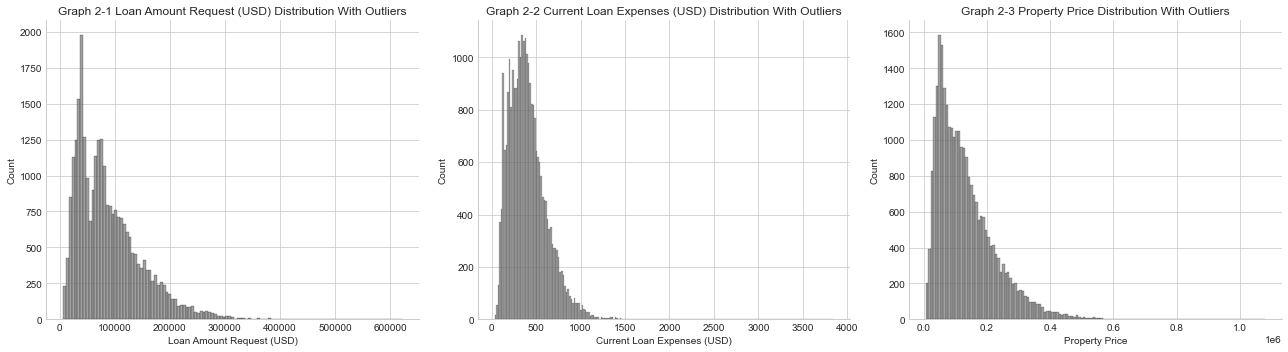

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 
sns.histplot(data=cleaned_train['Loan Amount Request (USD)'], ax=axes[0], color=cl)
axes[0].set_title('Graph 2-1 Loan Amount Request (USD) Distribution With Outliers')
sns.histplot(data=cleaned_train['Current Loan Expenses (USD)'], ax=axes[1], color=cl)
axes[1].set_title('Graph 2-2 Current Loan Expenses (USD) Distribution With Outliers')
sns.histplot(data=cleaned_train['Property Price'], ax=axes[2], color=cl)
axes[2].set_title('Graph 2-3 Property Price Distribution With Outliers')

plt.tight_layout()
sns.despine(right=True)
plt.show()

The distribution of "Income (USD)" in the dataset is as follows: 3.6% fall in the "Very Low" category, 31.8% in "Low," 41.3% in "Medium," 13.6% in "High," and 9.7% in "Very High." This distribution provides an overview of the income levels of loan applicants, allowing for targeted loan offers and risk assessment based on diverse income categories

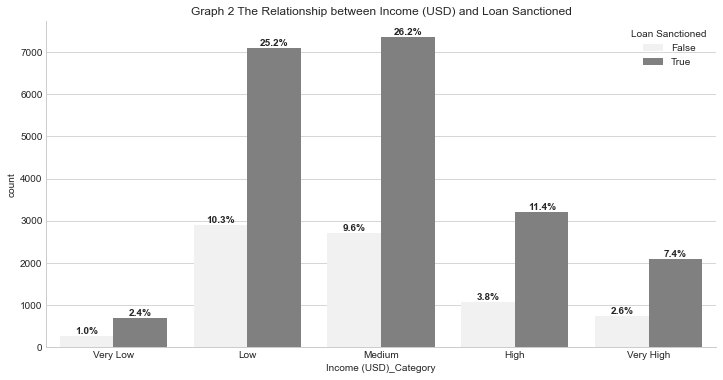

In [25]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=cleaned_train['Income (USD)_Category'], hue=cleaned_train['Loan Sanctioned'], color=cl)
ax.set(title='Graph 2 The Relationship between Income (USD) and Loan Sanctioned')

total_count = len(cleaned_train['Income (USD)_Category'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontweight='bold')

sns.despine(right=True)
plt.show()

the relationship between different professions and the loan sanction status (False or True) shows that proportion of loan sanctions is higher for individuals working as "Working" and "Commercial associate," while "Pensioner" and "State servant" have lower loan sanction rates. The "Other" category has the lowest loan sanction rate.

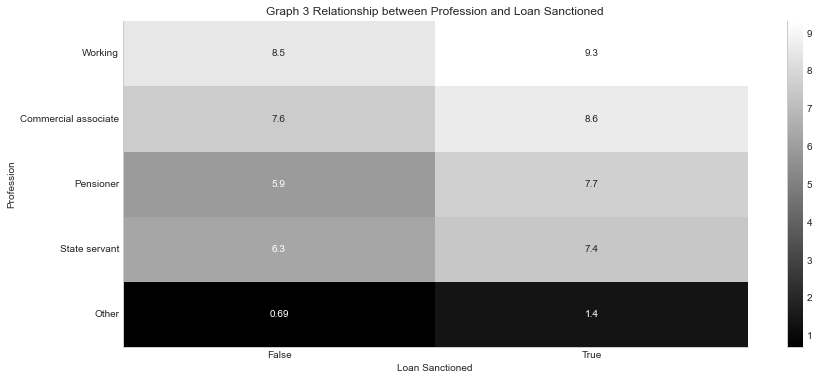

In [26]:
cross_tab = pd.crosstab(cleaned_train['Profession'], cleaned_train['Loan Sanctioned']).sort_values(True, ascending = False)

plt.figure(figsize=(14, 6))
sns.heatmap(np.log(cross_tab), annot=True, cmap='gray')
plt.xlabel('Loan Sanctioned')
plt.ylabel('Profession')

plt.title('Graph 3 Relationship between Profession and Loan Sanctioned')
sns.despine(right=True)
plt.show()

#### Inspecting Relationship between Category and Loan Sanction Amount (USD) variables
1. Gender, income stability, and no defaults exhibit a balanced relationship with the loan sanction amount.
2. Higher income levels correspond to higher loan sanction amounts, indicating a positive correlation between income and loan approval.
3. Urban locations tend to have slightly higher loan sanctions compared to rural and semi-urban areas.
4. Most professions show a balanced distribution in loan sanctions, except for the "unemployed" category.

These findings provide valuable insights into how different factors influence the loan sanction amount and can guide decision-making in loan approvals and risk assessment processes.



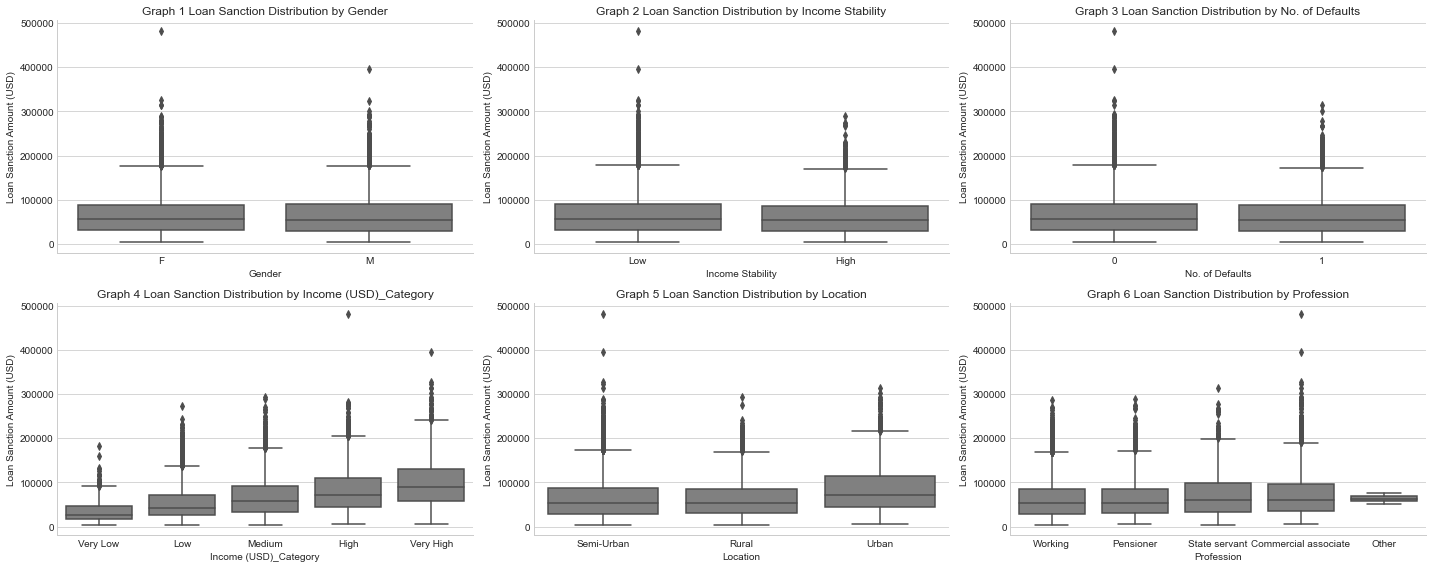

In [27]:
def plot_boxplots(df, columns_to_plot, n_rows=2, n_cols=3):
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
    # Flatten the axes for easy iteration
    axes = axes.flatten()
    for i, column in enumerate(columns_to_plot):
        sns.boxplot(data=df, x=column, y='Loan Sanction Amount (USD)', ax=axes[i], color=cl)
        axes[i].set_title(f'Graph {i+1} Loan Sanction Distribution by {column}')
        
    for j in range(len(columns_to_plot), n_rows * n_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    sns.despine(right=True)

    plt.show()

columns_to_plot = ['Gender', 'Income Stability', 'No. of Defaults', 'Income (USD)_Category', 'Location', 'Profession']
plot_boxplots(cleaned_train[cleaned_train['Loan Sanction Amount (USD)'] > 0], columns_to_plot)


#### Inspecting Relationship between numeric and Loan Sanctioned variables

The relationships between numeric variables and loan sanction shows:
A higher number of credits and co-applicants increase the chances of loan sanction.
Loan Amount Requested, Current Loan Expenses, Property Price, and Age impact the target value when they cross specific thresholds.
Having co-applicants positively influences the likelihood of loan approval.
Overall, there is a positive correlation between numeric features and loan sanction status.

Finding Relation between Loan Sanctioned and other continous featues: 


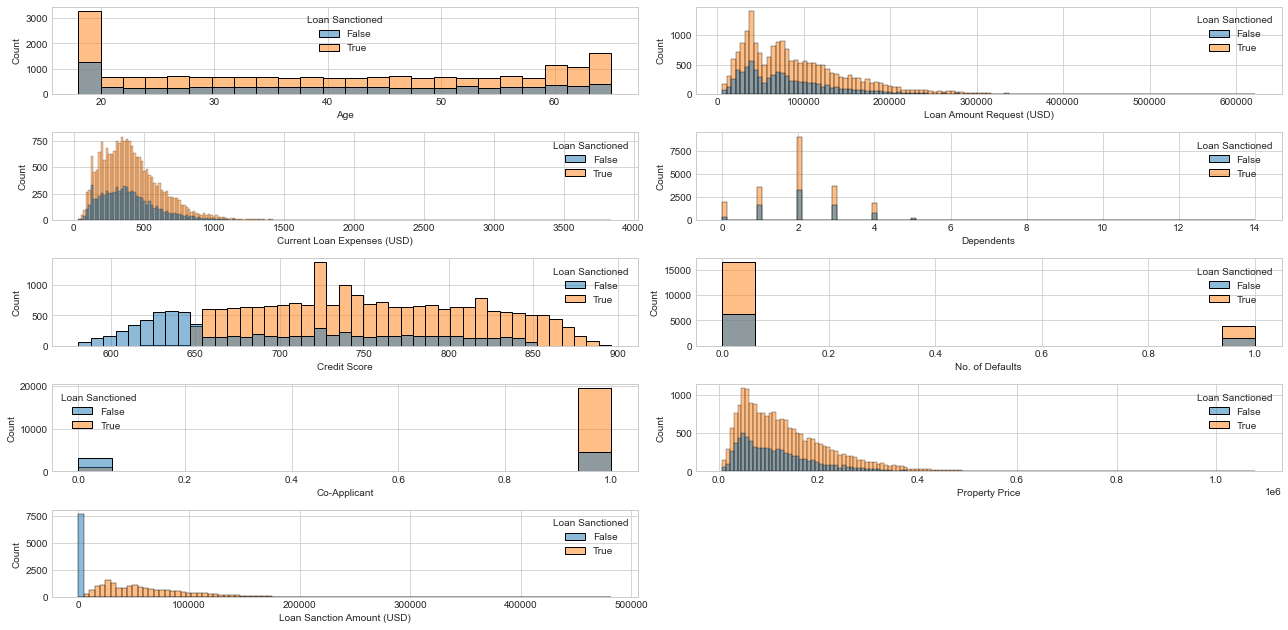

In [28]:
con_feats = cleaned_train.drop('Income (USD)', axis=1).select_dtypes(include=['float', 'int']).columns

plt.figure(figsize=(18, 12))
for index, col in enumerate(con_feats):
    if index == 1:
        legend = False
    plt.subplot(7, 2, index+1)
    sns.histplot(x=col, hue='Loan Sanctioned', data=cleaned_train, color=cl)

print("Finding Relation between Loan Sanctioned and other continous featues: ")
plt.tight_layout()

From our graph see that loan sanction is not affected by income that much

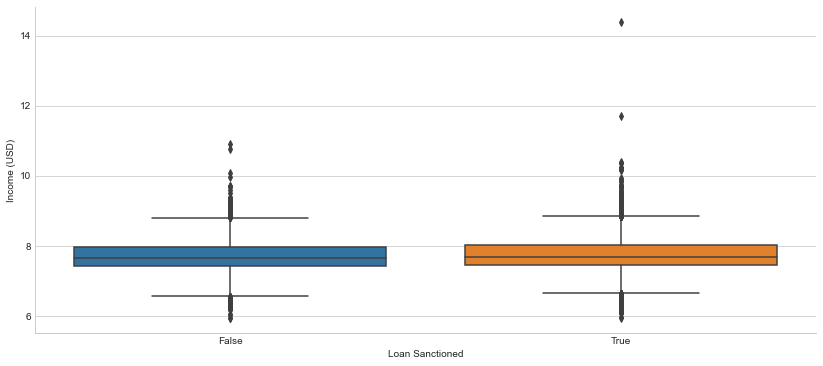

In [38]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=cleaned_train, y=np.log(cleaned_train['Income (USD)']), x="Loan Sanctioned")
sns.despine(right=True)
plt.show()

#### Correlations map
Looking at our correlation graph multicollinearity is not a significant concern, with the exception of two variables: "Loan Amount Request" and "Property Price." However, it is reasonable to expect a strong correlation between these two variables due to the influence of property price on loan amounts. As a result, we can use these variables interchangeably if necessary during the analysis.

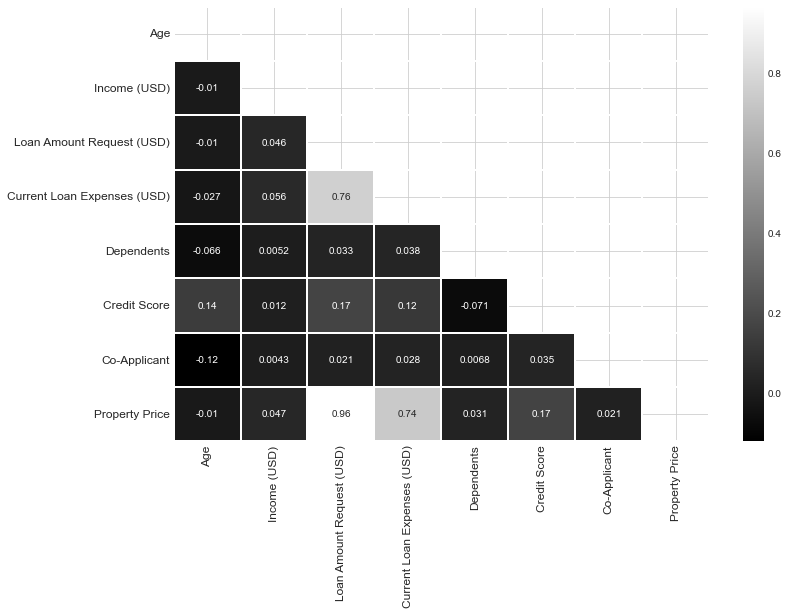

In [9]:
# compute correlation matrix
subset = ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 
          'Dependents', 'Credit Score', 'Property Type', 'Co-Applicant','Property Price']
corr_matrix = cleaned_train[subset].corr()

# create a mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(18,10))
# plot the heatmap
sns.heatmap(corr_matrix, annot=True, linewidths=0.2, cmap='gray', annot_kws={'size':10}, mask=mask)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [11]:
# Saving cleaned data for modeling
cleaned_train.to_csv('../datasets/cleaned_df.csv')